In [1]:
import requests
import dateutil
from dateutil import tz
import glob
import io
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pylab import imread,subplot,imshow,show
import seaborn as sns
from influxdb import InfluxDBClient

In [2]:
from sklearn.metrics import confusion_matrix
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, plot_roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, KernelPCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [3]:
nycd = gpd.read_file('nycd_21c/nycd.shp').to_crs('EPSG:4326')

In [4]:
sensors = pd.read_csv('sensor_locations.csv')
sensors = gpd.GeoDataFrame(sensors, geometry=gpd.points_from_xy(sensors['lng'], sensors['lat'], crs='EPSG:4326'))

In [5]:
r = requests.get('https://api.nysmesonet.org/data/dynserv/coned/5min/nyc/20211001T0000/20211002T0000?stations=bkbrow,bkmapl,bknyrd,bxvnst,mhalph,mhchel,mhmhil,qnasto,qncoro,qndkil,qnhbea,qnlici,qnmasp,qnsozo,qntlcc,sifkil&timezone=America/New_York&variables[]=tair@degF&variables[]=relh@percent&variables[]=lat@degrees&variables[]=lon@degrees')
stations = pd.read_csv(io.StringIO(r.text))
stations = stations.rename(columns={'lat [degrees]':'lat', 'lon [degrees]':'lon'})

In [6]:
stations = stations.groupby('station')[['lat','lon']].mean().reset_index()
stations.to_csv('micronet_stations.csv', index=False)

In [7]:
stations = gpd.GeoDataFrame(stations, geometry=gpd.points_from_xy(stations['lon'], stations['lat'], crs='EPSG:4326'))

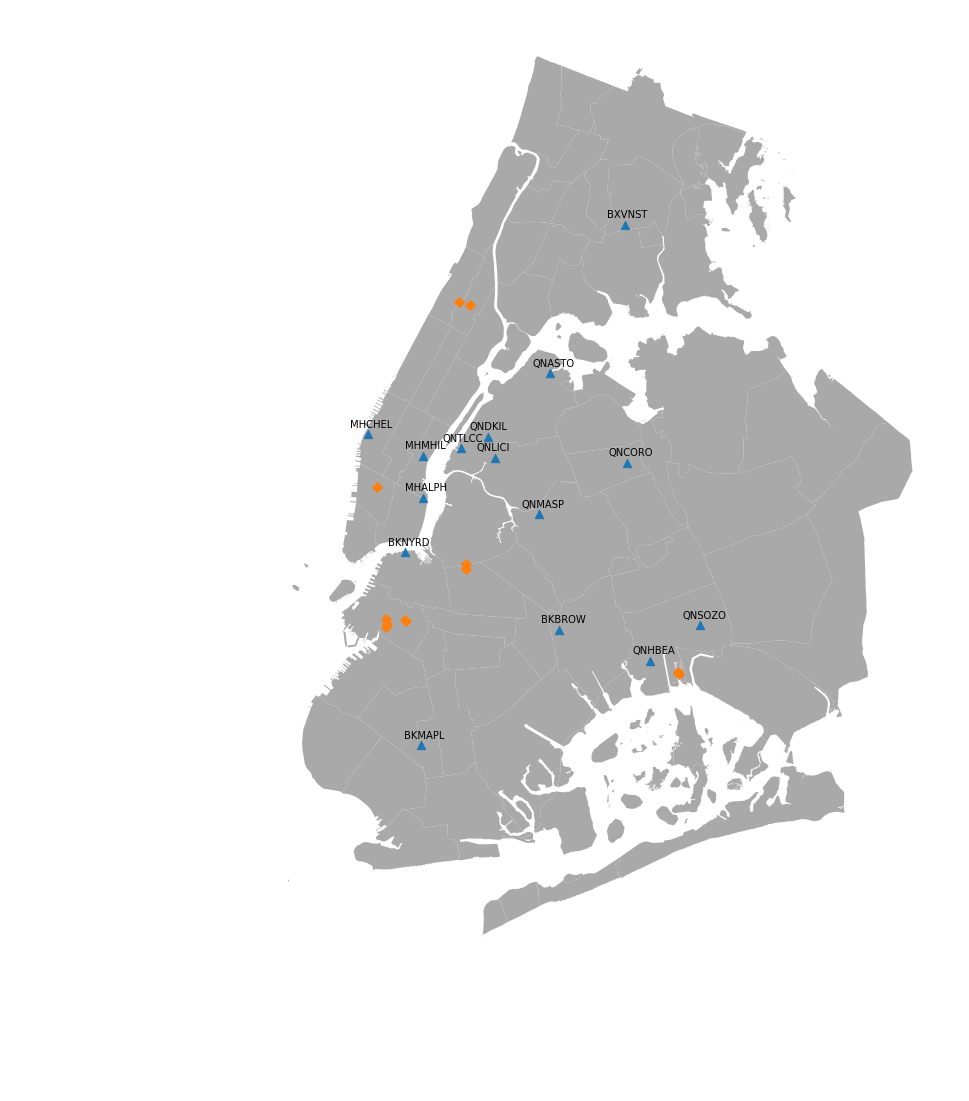

In [9]:
fig, ax = plt.subplots(figsize=(20,20))

nycd.plot(ax=ax, color='darkgray')
stations.plot(ax=ax, label=stations.station, marker='^', markersize=70)
sensors.plot(ax=ax, marker='D', markersize=50)
for i in range(len(stations)):
    plt.annotate(stations.station[i], (stations.lon[i] - 0.01, stations.lat[i] +0.003))
#ax.axis(xmin=-74.05, ymin=40.53)
ax.set_xlim(-74.05)
#ax.set_ylim(top=-74.05)
ax.axis('off')
plt.show()

### Query CSV data downloads

In [ ]:
r = requests.get('https://api.nysmesonet.org/data/dynserv/coned/5min/nyc/20201101T0000/20201201T0000?stations=bkbrow,bkmapl,bknyrd,bxvnst,mhalph,mhchel,mhmhil,qnasto,qncoro,qndkil,qnhbea,qnlici,qnmasp,qnsozo,qntlcc,sifkil&timezone=America/New_York&variables[]=tair@degF&variables[]=relh@percent')
df = pd.read_csv(io.StringIO(r.text)).iloc[:-1]
#df = df.groupby('datetime', as_index=False).median()
df.to_csv('micronet_temp2020_11.csv')


In [ ]:
r = requests.get('https://api.nysmesonet.org/data/dynserv/coned/5min/nyc/20201201T0000/20210101T0000?stations=bkbrow,bkmapl,bknyrd,bxvnst,mhalph,mhchel,mhmhil,qnasto,qncoro,qndkil,qnhbea,qnlici,qnmasp,qnsozo,qntlcc,sifkil&timezone=America/New_York&variables[]=tair@degF&variables[]=relh@percent')
df = pd.read_csv(io.StringIO(r.text)).iloc[:-1]
#df = df.groupby('datetime', as_index=False).median()
df.to_csv('micronet_temp2020_12.csv')


In [ ]:
month_dict = {}
year = '2021'
for month in range(1,12):
    month2 = str(month+1).zfill(2)
    month = str(month).zfill(2)
    
    print('Querying Month '+month)
    
    r = requests.get('https://api.nysmesonet.org/data/dynserv/coned/5min/nyc/'+year+month+'01T0000/'+year+month2+'01T0000?stations=bkbrow,bkmapl,bknyrd,bxvnst,mhalph,mhchel,mhmhil,qnasto,qncoro,qndkil,qnhbea,qnlici,qnmasp,qnsozo,qntlcc,sifkil&timezone=America/New_York&variables[]=tair@degF&variables[]=relh@percent')
    df = pd.read_csv(io.StringIO(r.text))
    df = df.groupby('datetime', as_index=False).median().iloc[:-1]
    df.to_csv('mesonet_temp2021_'+month+'.csv')
    month_dict[month] = df
    
                 

In [ ]:
r = requests.get('https://api.nysmesonet.org/data/dynserv/coned/5min/nyc/20211201T0000/20220101T0000?stations=bkbrow,bkmapl,bknyrd,bxvnst,mhalph,mhchel,mhmhil,qnasto,qncoro,qndkil,qnhbea,qnlici,qnmasp,qnsozo,qntlcc,sifkil&timezone=America/New_York&variables[]=tair@degF&variables[]=relh@percent')
df = pd.read_csv(io.StringIO(r.text)).iloc[:-1]
#df = df.groupby('datetime', as_index=False).median()
df.to_csv('micronet_temp2021_12.csv')

In [160]:
test = pd.concat(map(pd.read_csv, glob.glob('micronet_weather_aggregate/*.csv'))).iloc[:,1:].dropna()
test = test.rename(columns=cols)

# FORMAT WEATHER DATA

In [12]:
def F_to_C(F):
    C = (F - 32) * (5/9)
    return C

cols = {'datetime':'localtime', 'station':'station', 'temp_2m [degF]':'temp_F', 'relative_humidity [percent]':'humidity'}

temps = pd.concat(map(pd.read_csv, glob.glob('micronet_weather/*.csv'))).iloc[:,1:].dropna()
temps = temps.rename(columns=cols)
temps['temp_F'] = temps['temp_F'].astype(float)
temps['humidity'] = temps['humidity'].astype(float)
temps['localtime'] = temps['localtime'].str.replace(' EST', '-05:00', regex=True)
temps['localtime'] = temps['localtime'].str.replace(' EDT', '-04:00', regex=True)
temps['localtime'] = pd.to_datetime(temps['localtime'], utc=True).dt.tz_convert('US/Eastern')
temps.insert(2, 'temp_C', temps['temp_F'].apply(F_to_C))
temps.drop(columns='temp_F', inplace=True)
temps = temps.drop_duplicates()

In [13]:
temp_means = temps.groupby('localtime', as_index=False).mean()
temp_means = temp_means.resample('10min', on='localtime').mean().reset_index() ## resample at 10_min intervals

In [14]:
temps_dumbo = temps[temps['station'] == 'BKNYRD']
temps_dumbo = temps_dumbo.resample('10min', axis=0, closed='left',
 convention='start', kind=None, offset=None, origin='start_day', on='localtime').mean().reset_index() ## resample at 10_min intervals

In [15]:
temps_jbay = temps[temps['station'] == 'QNHBEA']
temps_jbay = temps_jbay.resample('10min', on='localtime').mean() ## resample at 10_min intervals

##### Hoyt & 5th - Gowanus

In [4]:
##### Query "Hoyt & 5th" Sensor Data from InfluxDB

client = InfluxDBClient(host='floodnet-influxdb.sonycproject.com', ssl=True, port=0, database='db0')

measure = 'distance'
table = 'msg'
app_id = 'deployment_one_app'
dev_id = 'sensor_2'
days_back = 800

query = 'SELECT "%s" ' \
        'FROM "%s" ' \
        'WHERE "app_id" = \'%s\' ' \
        'AND "dev_id" = \'%s\' ' \
        'AND "time" >= now() - %id'\
        % (measure, table, app_id, dev_id, days_back)

data = client.query(query)

value_data = data.raw['series'][0]['values']

hoyt_5th = pd.DataFrame(value_data, columns =['datetime', 'distance'])

hoyt_5th['datetime'] = pd.to_datetime(hoyt_5th['datetime'], format='%Y-%m-%dT%H:%M:%S.%f')
hoyt_5th['localtime'] = hoyt_5th['datetime'].dt.tz_convert('US/Eastern')

hoyt_5th = pd.DataFrame(hoyt_5th.resample('10min', on='localtime').distance.mean()).reset_index() ## resample at 10_min intervals
hoyt_5th = hoyt_5th[(hoyt_5th.localtime.dt.date > pd.Timestamp(year=2020, month=11, day=1))]
print(hoyt_5th)

//anaconda3/lib/python3.7/site-packages/urllib3/connectionpool.py:1020: InsecureRequestWarning: Unverified HTTPS request is being made to host 'floodnet-influxdb.sonycproject.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,


                      localtime     distance
5956  2020-11-02 00:00:00-05:00  2702.500000
5957  2020-11-02 00:10:00-05:00  2703.500000
5958  2020-11-02 00:20:00-05:00  2704.666667
5959  2020-11-02 00:30:00-05:00  2707.500000
5960  2020-11-02 00:40:00-05:00  2703.333333
...                         ...          ...
59043 2021-11-05 16:50:00-04:00  2741.000000
59044 2021-11-05 17:00:00-04:00  2713.333333
59045 2021-11-05 17:10:00-04:00  2710.000000
59046 2021-11-05 17:20:00-04:00  2705.000000
59047 2021-11-05 17:30:00-04:00  2703.000000

[53092 rows x 2 columns]


In [97]:
n_hoyt5th = hoyt_5th[(hoyt_5th.localtime.dt.hour > 22) | (hoyt_5th.localtime.dt.hour < 5)]
n_hoyt5th = n_hoyt5th.set_index('localtime')

In [98]:
## Drop 5000s, anomalous Snowy February,  December 2020 Flood Event

nc_hoyt5th = n_hoyt5th[n_hoyt5th['distance'] < 4500]
nc_hoyt5th = nc_hoyt5th[nc_hoyt5th.index.month != 2] ## Omit Snowy February
nc_hoyt5th = nc_hoyt5th[~(nc_hoyt5th.index.date == pd.Timestamp(month=1, year=2021, day=31))]# Remove 1/31 - also snowy

nc_hoyt5th = nc_hoyt5th[(nc_hoyt5th.index.date < pd.Timestamp(year=2020, month=12, day=15))\
| (nc_hoyt5th.index.date > pd.Timestamp(year=2020, month=12, day=22))] # Omit December Flood Event

<AxesSubplot:xlabel='localtime'>

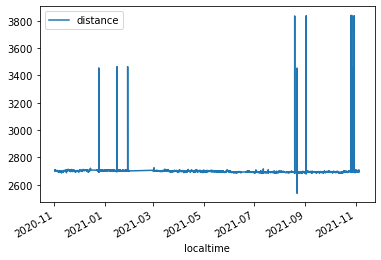

In [99]:
nc_hoyt5th.plot()

In [100]:
lower_hoyt5th = nc_hoyt5th['distance'].mean() - (nc_hoyt5th['distance'].std())
upper_hoyt5th = nc_hoyt5th['distance'].mean() + (nc_hoyt5th['distance'].std())

In [101]:
### Remove readings 3STDs from mean distance
nc_hoyt5th = nc_hoyt5th[nc_hoyt5th['distance'] < upper_hoyt5th]
nc_hoyt5th = nc_hoyt5th[nc_hoyt5th['distance'] > lower_hoyt5th]

Text(0, 0.5, 'Distance (cm)')

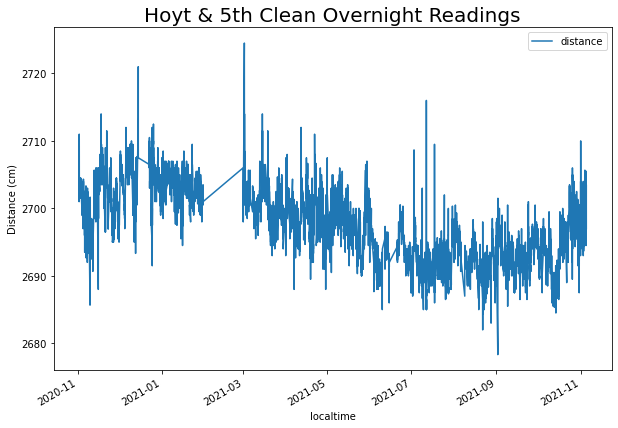

In [102]:
nc_hoyt5th.plot(figsize=(10,7))
plt.title('Hoyt & 5th Clean Overnight Readings', fontsize=20)
plt.ylabel('Distance (cm)')

In [103]:
nc_hoyt5th = nc_hoyt5th.merge(temps_dumbo, left_on= nc_hoyt5th.index, right_on= temps_dumbo.localtime, how='inner')

In [ ]:
nc_hoyt5th = nc_hoyt5th.set_index('localtime').dropna().drop(columns='key_0')

In [110]:
nc_hoyt5th

,distance,temp_C,humidity
localtime,,,
2020-11-02 00:00:00-05:00,2702.500000,7.250000,53.400
2020-11-02 00:10:00-05:00,2703.500000,7.083333,53.125
2020-11-02 00:20:00-05:00,2704.666667,6.930556,53.350
2020-11-02 00:30:00-05:00,2707.500000,6.763889,53.075
2020-11-02 00:40:00-05:00,2703.333333,6.583333,52.700
...,...,...,...
2021-11-05 04:10:00-04:00,2700.000000,6.208333,53.850
2021-11-05 04:20:00-04:00,2700.333333,6.166667,54.125
2021-11-05 04:30:00-04:00,2703.000000,6.125000,54.200


Text(0, 0.5, 'Distance')

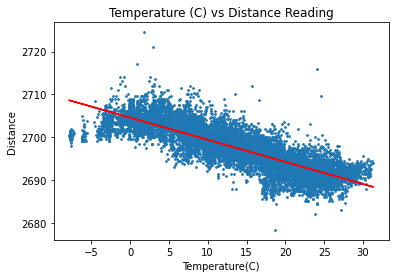

In [111]:
x_1 = nc_hoyt5th['temp_C']
x_2 = nc_hoyt5th['humidity']
y = nc_hoyt5th['distance']

plt.scatter(x_1, y, s=3)
m, b = np.polyfit(x_1, y, 1)
plt.plot(x_1, m*x_1 + b, color='red')
plt.title('Temperature (C) vs Distance Reading')
plt.xlabel('Temperature(C)')
plt.ylabel('Distance')

Text(0, 0.5, 'Distance')

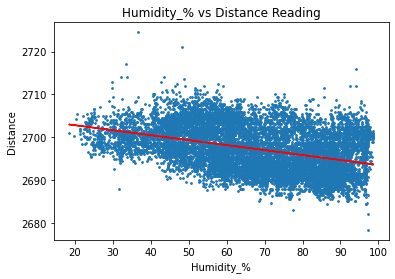

In [112]:
plt.scatter(x_2, y, s=3)
m, b = np.polyfit(x_2, y, 1)
plt.plot(x_2, m*x_2 + b, color='red')
plt.title('Humidity_% vs Distance Reading')
plt.xlabel('Humidity_%')
plt.ylabel('Distance')

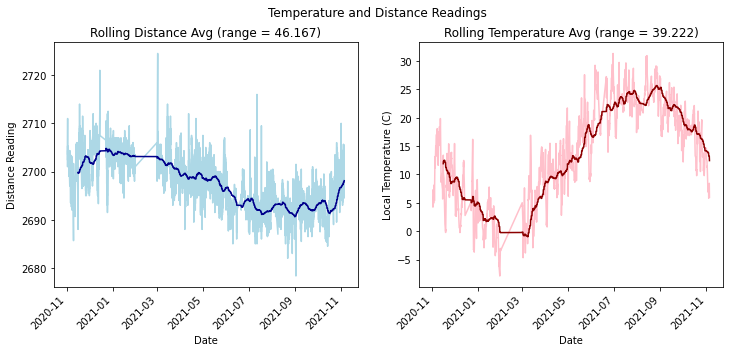

In [113]:
fig, ax = plt.subplots(1,2, figsize= (12,5))

nc_hoyt5th['distance'].plot(label='Dist', color='lightblue', ax=ax[0])
nc_hoyt5th['distance'].rolling(500).mean().plot(label='Dist', color='darkblue', ax=ax[0])
dist_range = round(nc_hoyt5th['distance'].max() - nc_hoyt5th['distance'].min(), 3)
ax[0].set_title(f'Rolling Distance Avg (range = {dist_range})')
ax[0].set_ylabel('Distance Reading')

nc_hoyt5th['temp_C'].plot(label='Temp', color='pink', ax=ax[1])
nc_hoyt5th['temp_C'].rolling(500).mean().plot(label='Temp', color='darkred', ax=ax[1])
temp_range = round(nc_hoyt5th['temp_C'].max() - nc_hoyt5th['temp_C'].min(), 3)
plt.suptitle('Temperature and Distance Readings')
ax[1].set_title(f'Rolling Temperature Avg (range = {temp_range})')
ax[1].set_ylabel('Local Temperature (C)')

for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=45)
    plt.xlabel('Date')

In [114]:
#### Temperature + Humdity

y = nc_hoyt5th['distance']
X = pd.DataFrame(nc_hoyt5th[['temp_C','humidity']])

n = 4

X_poly = X.copy()

for i in range(2,n+1):
    X_poly[f'temp_x{i}'] = nc_hoyt5th['temp_C']**i
    
for i in range(2,n+1):
    X_poly[f'humid_x{i}'] = nc_hoyt5th['humidity']**i


In [115]:
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.3)

lm = sm.OLS(y_train, sm.add_constant(X_train)).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               distance   R-squared:                       0.756
Model:                            OLS   Adj. R-squared:                  0.755
Method:                 Least Squares   F-statistic:                     3122.
Date:                Fri, 13 May 2022   Prob (F-statistic):               0.00
Time:                        17:11:38   Log-Likelihood:                -19223.
No. Observations:                8085   AIC:                         3.846e+04
Df Residuals:                    8076   BIC:                         3.853e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2700.8891      2.566   1052.405      0.000    2695.858    2705.920
temp_C         0.0910      0.017      5.345      0.000       0.058       0.124
humidity       0.0578      0.190      0.305      0.760      -0.314       0.429
temp_x2       -0.0641      0.003    -22.465      0.000      -0.070      -0.059
temp_x3        0.0021      0.000     11.088      0.000       0.002       0.002
temp_x4    -1.747e-05   3.82e-06     -4.580      0.000    -2.5e-05      -1e-05
humid_x2       0.0043      0.005      0.865      0.387      -0.005       0.014
humid_x3      -0.0001   5.56e-05     -1.975      0.048      -0.000   -8.24e-07
humid_x4    6.346e-07   2.23e-07      2.840      0.005    1.97e-07    1.07e-06
==============================================================================
Omnibus:                      372.848   Durbin-Watson:                   1.950
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1268.481
Skew:                           0.087   Prob(JB):                    3.57e-276
Kurtosis:                       4.933   Cond. No.                     3.35e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.35e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [116]:
pred = lm.predict(sm.add_constant(X_test))

r2 = r2_score(y_test, pred)
mae = mean_absolute_error(y_test,pred)
print(r2, mae)


0.7533011728698675 2.0030763426416445


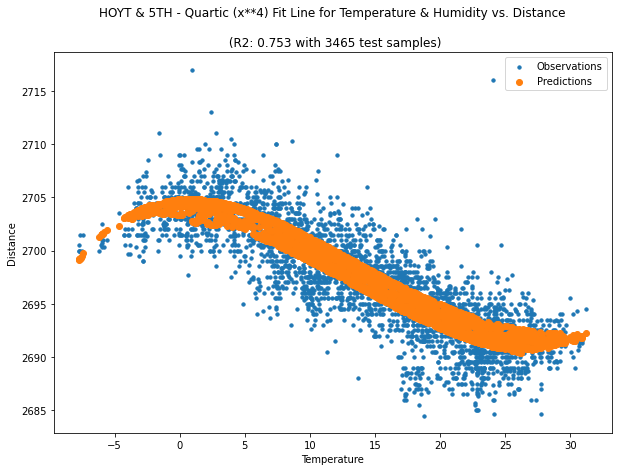

In [117]:
plt.figure(figsize=(10,7))

#plt.plot(X_train_temp, lm_temp.params[1]*X_train_temp+lm_temp.params[0], color='green')
plt.scatter(X_test['temp_C'], y_test, s=11, label='Observations')
plt.scatter(X_test['temp_C'], pred, label='Predictions')
plt.title('HOYT & 5TH - Quartic (x**4) Fit Line for Temperature & Humidity vs. Distance\
\n\n (R2: {:.3f} with {:n} test samples)'.format(r2, len(X_test)))
plt.xlabel('Temperature')
plt.ylabel('Distance')
plt.legend()

In [118]:
lm.params

const       2.700889e+03
temp_C      9.097987e-02
humidity    5.781057e-02
temp_x2    -6.409485e-02
temp_x3     2.094411e-03
temp_x4    -1.747455e-05
humid_x2    4.313160e-03
humid_x3   -1.098747e-04
humid_x4    6.345710e-07
dtype: float64

# Smith & 9th - Gowanus

In [51]:
##### Query "Smith & 9th" Sensor Data from InfluxDB

client = InfluxDBClient(host='floodnet-influxdb.sonycproject.com', ssl=True, port=0, database='db0')

measure = 'distance'
table = 'deployment-3'
dev_id = 'smith-and-9th'
days_back = 600

query = 'SELECT "%s" ' \
        'FROM "%s" ' \
        'WHERE "dev_id" = \'%s\' ' \
        'AND "time" >= now() - %id'\
        % (measure, table, dev_id, days_back)

data = client.query(query)

value_data = data.raw['series'][0]['values']

smith_9th = pd.DataFrame(value_data, columns =['datetime', 'distance'])

smith_9th['datetime'] = pd.to_datetime(smith_9th['datetime'], format='%Y-%m-%dT%H:%M:%S.%f')
smith_9th['localtime'] = smith_9th['datetime'].dt.tz_convert('US/Eastern')

smith_9th = pd.DataFrame(smith_9th.resample('10min', on='localtime').distance.mean()).reset_index() ## resample at 10_min intervals

print(smith_9th)

//anaconda3/lib/python3.7/site-packages/urllib3/connectionpool.py:1020: InsecureRequestWarning: Unverified HTTPS request is being made to host 'floodnet-influxdb.sonycproject.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,


                      localtime  distance
0     2021-07-01 17:30:00-04:00    1464.0
1     2021-07-01 17:40:00-04:00       NaN
2     2021-07-01 17:50:00-04:00       NaN
3     2021-07-01 18:00:00-04:00    1992.0
4     2021-07-01 18:10:00-04:00    1283.0
...                         ...       ...
23332 2021-12-10 17:10:00-05:00     300.0
23333 2021-12-10 17:20:00-05:00     300.0
23334 2021-12-10 17:30:00-05:00     300.0
23335 2021-12-10 17:40:00-05:00     300.0
23336 2021-12-10 17:50:00-05:00     300.0

[23337 rows x 2 columns]


In [207]:
n_smith_9th = smith_9th[(smith_9th.localtime.dt.hour > 22) | (smith_9th.localtime.dt.hour < 5)]
#n_smith_9th = n_smith_9th.set_index('localtime')

In [208]:
## Drop 5000s, anomalous Snowy February,  December 2020 Flood Event

cln_smith_9th = n_smith_9th[n_smith_9th['distance'] < 4500]
#cln_smith_9th = cln_smith_9th[cln_smith_9th.index.month != 2] ## Omit Snowy February
#cln_smith_9th = cln_smith_9th[~(cln_smith_9th.index.date == pd.Timestamp(month=1, year=2021, day=31))]# Remove 1/31 - also snowy
cln_smith_9th = cln_smith_9th[(cln_smith_9th.localtime.dt.date > pd.Timestamp(year=2021, month=7, day=14))]

<AxesSubplot:xlabel='localtime'>

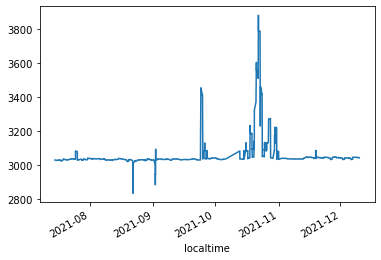

In [209]:
cln_smith_9th.set_index('localtime')['distance'].rolling(21).mean().plot()

In [210]:
lower_smith_9th = cln_smith_9th['distance'].mean() - (cln_smith_9th['distance'].std())
upper_smith_9th = cln_smith_9th['distance'].mean() + (cln_smith_9th['distance'].std())

In [211]:
cln_smith_9th = cln_smith_9th[cln_smith_9th['distance'] < upper_smith_9th]
cln_smith_9th = cln_smith_9th[cln_smith_9th['distance'] > lower_smith_9th]

In [212]:
cln_smith_9th = cln_smith_9th[cln_smith_9th['distance'] > 3000]

Text(0, 0.5, 'Distance (cm)')

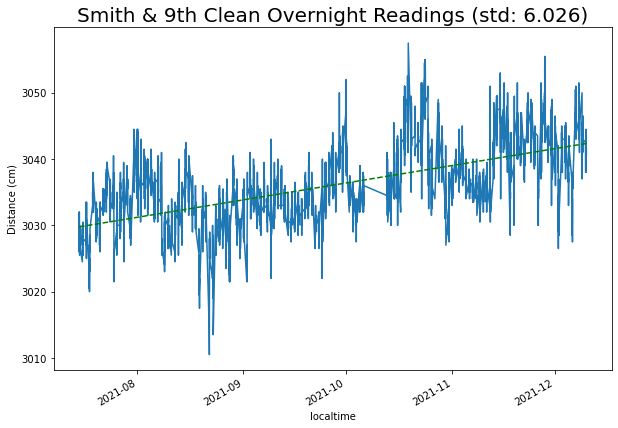

In [213]:
cln_smith_9th.set_index('localtime')['distance'].plot(figsize=(10,7))

x = mdates.date2num(cln_smith_9th['localtime'])
z = np.polyfit(x, cln_smith_9th['distance'], 1)
p = np.poly1d(z)
plt.plot(x, p(x), "g--")
std = round(cln_smith_9th['distance'].std(), 3)

plt.title(f'Smith & 9th Clean Overnight Readings (std: {std})', fontsize=20)
plt.ylabel('Distance (cm)')

In [95]:
## merge weather and sensor data and drop NaN values

cln_smith_9th = cln_smith_9th.merge(temps_dumbo, on='localtime',how='outer').dropna()
cln_smith_9th = cln_smith_9th.set_index('localtime').dropna()

Text(0, 0.5, 'Distance')

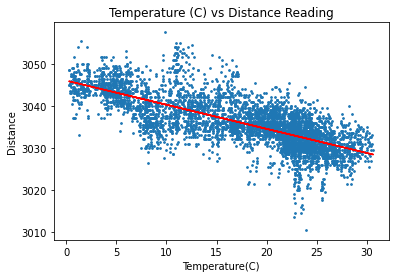

In [431]:
x_1 = cln_smith_9th['temp_C']
x_2 = cln_smith_9th['humidity']
y = cln_smith_9th['distance']

plt.scatter(x_1, y, s=3)
m, b = np.polyfit(x_1, y, 1)
plt.plot(x_1, m*x_1 + b, color='red')
plt.title('Temperature (C) vs Distance Reading')
plt.xlabel('Temperature(C)')
plt.ylabel('Distance')

Text(0, 0.5, 'Distance')

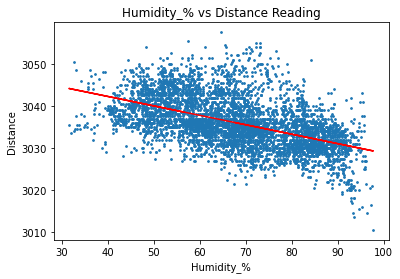

In [432]:
plt.scatter(x_2, y, s=3)
m, b = np.polyfit(x_2, y, 1)
plt.plot(x_2, m*x_2 + b, color='red')
plt.title('Humidity_% vs Distance Reading')
plt.xlabel('Humidity_%')
plt.ylabel('Distance')

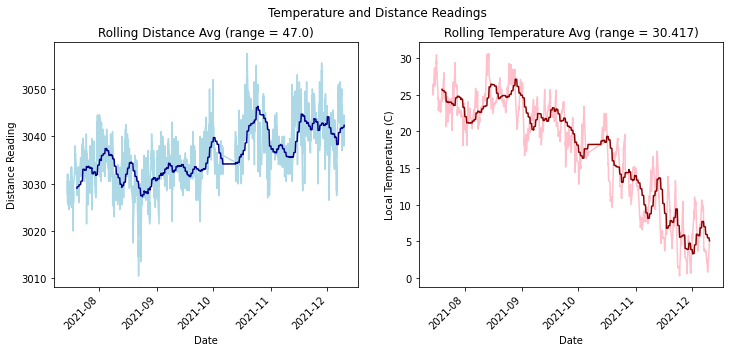

In [433]:
fig, ax = plt.subplots(1,2, figsize= (12,5))

cln_smith_9th['distance'].plot(label='Dist', color='lightblue', ax=ax[0])
cln_smith_9th['distance'].rolling(180).mean().plot(label='Dist', color='darkblue', ax=ax[0])
dist_range = round(cln_smith_9th['distance'].max() - cln_smith_9th['distance'].min(), 3)
ax[0].set_title(f'Rolling Distance Avg (range = {dist_range})')
ax[0].set_ylabel('Distance Reading')

cln_smith_9th['temp_C'].plot(label='Temp', color='pink', ax=ax[1])
cln_smith_9th['temp_C'].rolling(180).mean().plot(label='Temp', color='darkred', ax=ax[1])
temp_range = round(cln_smith_9th['temp_C'].max() - cln_smith_9th['temp_C'].min(), 3)
plt.suptitle('Temperature and Distance Readings')
ax[1].set_title(f'Rolling Temperature Avg (range = {temp_range})')
ax[1].set_ylabel('Local Temperature (C)')

for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=45)
    plt.xlabel('Date')

In [434]:
cln_smith_9th['distance'].std()

6.025751661551884

In [435]:
#### Temperature + Humdity

y = cln_smith_9th['distance']
X = pd.DataFrame(cln_smith_9th[['temp_C','humidity']])

n = 4

X_poly = X.copy()

for i in range(2,n+1):
    X_poly[f'temp_x{i}'] = cln_smith_9th['temp_C']**i
    
for i in range(2,n+1):
    X_poly[f'humid_x{i}'] = cln_smith_9th['humidity']**i


In [436]:
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.3)

lm = sm.OLS(y_train, sm.add_constant(X_train)).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               distance   R-squared:                       0.655
Model:                            OLS   Adj. R-squared:                  0.654
Method:                 Least Squares   F-statistic:                     818.2
Date:                Fri, 21 Jan 2022   Prob (F-statistic):               0.00
Time:                        14:07:57   Log-Likelihood:                -9274.9
No. Observations:                3453   AIC:                         1.857e+04
Df Residuals:                    3444   BIC:                         1.862e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2977.1682     17.920    166.136      0.000    2942.033    3012.303
temp_C        -1.8051      0.193     -9.336      0.000      -2.184      -1.426
humidity       4.1730      1.157      3.606      0.000       1.904       6.442
temp_x2        0.1832      0.024      7.619      0.000       0.136       0.230
temp_x3       -0.0084      0.001     -7.298      0.000      -0.011      -0.006
temp_x4        0.0001   1.84e-05      6.453      0.000    8.27e-05       0.000
humid_x2      -0.0903      0.027     -3.284      0.001      -0.144      -0.036
humid_x3       0.0009      0.000      3.066      0.002       0.000       0.001
humid_x4   -3.262e-06   1.08e-06     -3.032      0.002   -5.37e-06   -1.15e-06
==============================================================================
Omnibus:                      143.777   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              266.802
Skew:                           0.319   Prob(JB):                     1.16e-58
Kurtosis:                       4.203   Cond. No.                     9.78e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.78e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [438]:
pred = lm.predict(sm.add_constant(X_test))

r2 = r2_score(y_test, pred)
print(r2)

0.643523856662285


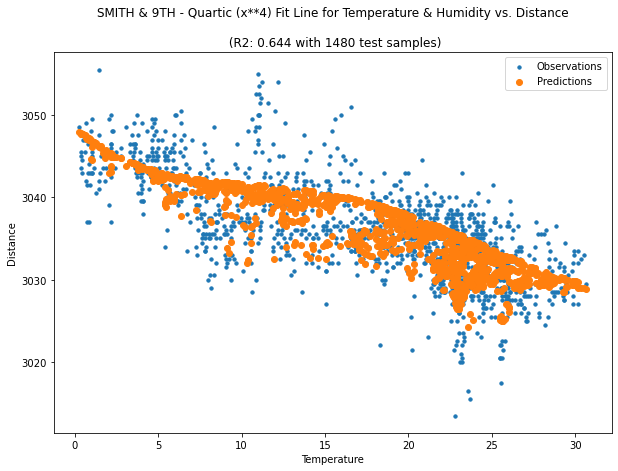

In [441]:
plt.figure(figsize=(10,7))
#plt.plot(X_train_temp, lm_temp.params[1]*X_train_temp+lm_temp.params[0], color='green')
plt.scatter(X_test['temp_C'], y_test, s=11, label='Observations')
plt.scatter(X_test['temp_C'], pred, label='Predictions')
plt.title('SMITH & 9TH - Quartic (x**4) Fit Line for Temperature & Humidity vs. Distance\
\n\n (R2: {:.3f} with {:n} test samples)'.format(r2, len(X_test)))
plt.xlabel('Temperature')
plt.ylabel('Distance')
plt.legend()

# Carroll & 4th - Gowanus

In [194]:
##### Query "Carroll & 4th" Sensor Data from InfluxDB

client = InfluxDBClient(host='floodnet-influxdb.sonycproject.com', ssl=True, port=0, database='db0')

measure = 'distance'
table = 'deployment-3'
dev_id = 'carroll-and-4th'
days_back = 600

query = 'SELECT "%s" ' \
        'FROM "%s" ' \
        'WHERE "dev_id" = \'%s\' ' \
        'AND "time" >= now() - %id'\
        % (measure, table, dev_id, days_back)

data = client.query(query)

value_data = data.raw['series'][0]['values']

carroll4th = pd.DataFrame(value_data, columns =['datetime', 'distance'])

carroll4th['datetime'] = pd.to_datetime(carroll4th['datetime'], format='%Y-%m-%dT%H:%M:%S.%f')
carroll4th['localtime'] = carroll4th['datetime'].dt.tz_convert('US/Eastern')

carroll4th = pd.DataFrame(carroll4th.resample('10min', on='localtime').distance.mean()).reset_index() ## resample at 10_min intervals
carroll4th = carroll4th.dropna()

print(carroll4th)

//anaconda3/lib/python3.7/site-packages/urllib3/connectionpool.py:1020: InsecureRequestWarning: Unverified HTTPS request is being made to host 'floodnet-influxdb.sonycproject.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,


                      localtime  distance
0     2021-07-01 18:10:00-04:00    1307.0
1     2021-07-01 18:20:00-04:00    1308.0
2     2021-07-01 18:30:00-04:00    1307.0
3     2021-07-01 18:40:00-04:00    1306.5
4     2021-07-01 18:50:00-04:00    1307.0
...                         ...       ...
22720 2021-12-06 11:50:00-05:00       0.0
23003 2021-12-08 11:00:00-05:00       0.0
23006 2021-12-08 11:30:00-05:00       0.0
23310 2021-12-10 14:10:00-05:00       0.0
23311 2021-12-10 14:20:00-05:00       0.0

[18626 rows x 2 columns]


<AxesSubplot:>

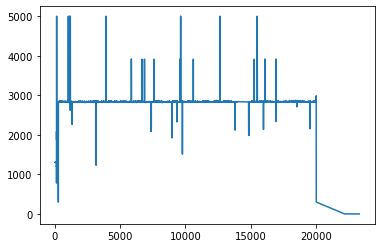

In [195]:
carroll4th['distance'].plot()

In [214]:
n_carroll4th = carroll4th[(carroll4th.localtime.dt.hour > 22) | (carroll4th.localtime.dt.hour < 5)]

In [215]:
cln_carroll4th = n_carroll4th[n_carroll4th['distance'] < 4500]
#cln_smith_9th = cln_smith_9th[cln_smith_9th.index.month != 2] ## Omit Snowy February
#cln_smith_9th = cln_smith_9th[~(cln_smith_9th.index.date == pd.Timestamp(month=1, year=2021, day=31))]# Remove 1/31 - also snowy
cln_carroll4th = cln_carroll4th[(cln_carroll4th.localtime.dt.date > pd.Timestamp(year=2021, month=7, day=14))]

In [216]:
lower_carroll4th = cln_carroll4th['distance'].mean() - (cln_carroll4th['distance'].std())
upper_carroll4th = cln_carroll4th['distance'].mean() + (cln_carroll4th['distance'].std())

In [217]:
cln_carroll4th = cln_carroll4th[cln_carroll4th['distance'] < upper_carroll4th]
cln_carroll4th = cln_carroll4th[cln_carroll4th['distance'] > lower_carroll4th]

Text(0, 0.5, 'Distance (cm)')

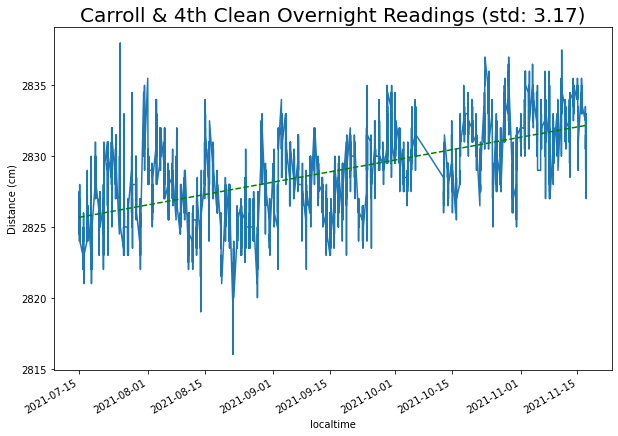

In [218]:
cln_carroll4th.set_index('localtime')['distance'].plot(figsize=(10,7))

x = mdates.date2num(cln_carroll4th['localtime'])
z = np.polyfit(x, cln_carroll4th['distance'], 1)
p = np.poly1d(z)
plt.plot(x, p(x), "g--")
std = round(cln_carroll4th['distance'].std(), 3)

plt.title(f'Carroll & 4th Clean Overnight Readings (std: {std})', fontsize=20)
plt.ylabel('Distance (cm)')

In [412]:
cln_carroll4th = cln_carroll4th.merge(temps_dumbo, on='localtime',how='inner').dropna()
cln_carroll4th = cln_carroll4th.set_index('localtime').dropna()

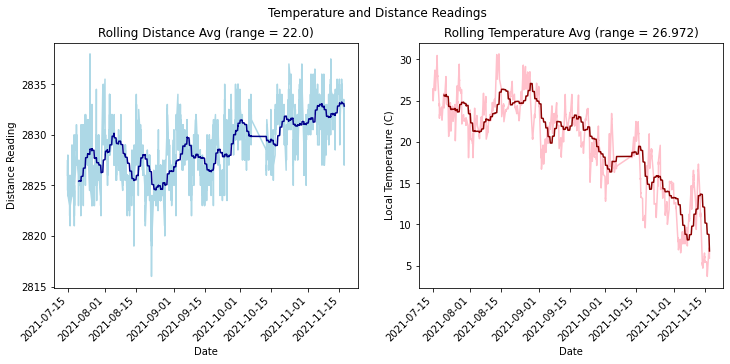

In [413]:
fig, ax = plt.subplots(1,2, figsize= (12,5))

cln_carroll4th['distance'].plot(label='Dist', color='lightblue', ax=ax[0])
cln_carroll4th['distance'].rolling(180).mean().plot(label='Dist', color='darkblue', ax=ax[0])
dist_range = round(cln_carroll4th['distance'].max() - cln_carroll4th['distance'].min(), 3)
ax[0].set_title(f'Rolling Distance Avg (range = {dist_range})')
ax[0].set_ylabel('Distance Reading')

cln_carroll4th['temp_C'].plot(label='Temp', color='pink', ax=ax[1])
cln_carroll4th['temp_C'].rolling(180).mean().plot(label='Temp', color='darkred', ax=ax[1])
temp_range = round(cln_carroll4th['temp_C'].max() - cln_carroll4th['temp_C'].min(), 3)
plt.suptitle('Temperature and Distance Readings')
ax[1].set_title(f'Rolling Temperature Avg (range = {temp_range})')
ax[1].set_ylabel('Local Temperature (C)')

for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=45)
    plt.xlabel('Date')

In [414]:
cln_carroll4th['distance'].std()

3.170076658202941

Text(0, 0.5, 'Distance')

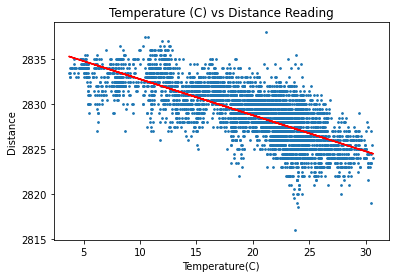

In [415]:
x_1 = cln_carroll4th['temp_C']
x_2 = cln_carroll4th['humidity']
y = cln_carroll4th['distance']

plt.scatter(x_1, y, s=3)
m, b = np.polyfit(x_1, y, 1)
plt.plot(x_1, m*x_1 + b, color='red')
plt.title('Temperature (C) vs Distance Reading')
plt.xlabel('Temperature(C)')
plt.ylabel('Distance')

Text(0, 0.5, 'Distance')

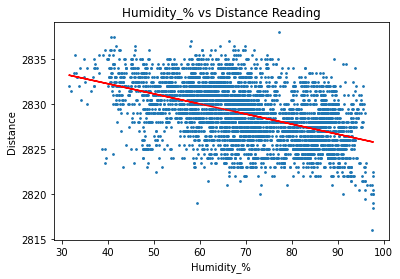

In [416]:
plt.scatter(x_2, y, s=3)
m, b = np.polyfit(x_2, y, 1)
plt.plot(x_2, m*x_2 + b, color='red')
plt.title('Humidity_% vs Distance Reading')
plt.xlabel('Humidity_%')
plt.ylabel('Distance')

In [417]:
#### Temperature + Humdity

y = cln_carroll4th['distance']
X = pd.DataFrame(cln_carroll4th[['temp_C','humidity']])

n = 4

X_poly = X.copy()

for i in range(2,n+1):
    X_poly[f'temp_x{i}'] = cln_carroll4th['temp_C']**i
    
for i in range(2,n+1):
    X_poly[f'humid_x{i}'] = cln_carroll4th['humidity']**i


In [418]:
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.3)

lm = sm.OLS(y_train, sm.add_constant(X_train)).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               distance   R-squared:                       0.724
Model:                            OLS   Adj. R-squared:                  0.724
Method:                 Least Squares   F-statistic:                     976.7
Date:                Fri, 21 Jan 2022   Prob (F-statistic):               0.00
Time:                        14:04:35   Log-Likelihood:                -5756.3
No. Observations:                2984   AIC:                         1.153e+04
Df Residuals:                    2975   BIC:                         1.158e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2820.3478      9.113    309.474      0.000    2802.479    2838.217
temp_C        -1.2382      0.313     -3.958      0.000      -1.852      -0.625
humidity       1.0870      0.577      1.884      0.060      -0.044       2.218
temp_x2        0.1304      0.031      4.247      0.000       0.070       0.191
temp_x3       -0.0059      0.001     -4.739      0.000      -0.008      -0.003
temp_x4     8.044e-05   1.75e-05      4.591      0.000    4.61e-05       0.000
humid_x2      -0.0240      0.014     -1.765      0.078      -0.051       0.003
humid_x3       0.0002      0.000      1.629      0.103   -4.62e-05       0.001
humid_x4   -8.445e-07   5.24e-07     -1.611      0.107   -1.87e-06    1.83e-07
==============================================================================
Omnibus:                       66.482   Durbin-Watson:                   2.030
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              146.194
Skew:                           0.024   Prob(JB):                     1.80e-32
Kurtosis:                       4.083   Cond. No.                     1.07e+10
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.07e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [420]:
pred = lm.predict(sm.add_constant(X_test))

r2 = r2_score(y_test, pred)
print(r2)

0.7050228177000127


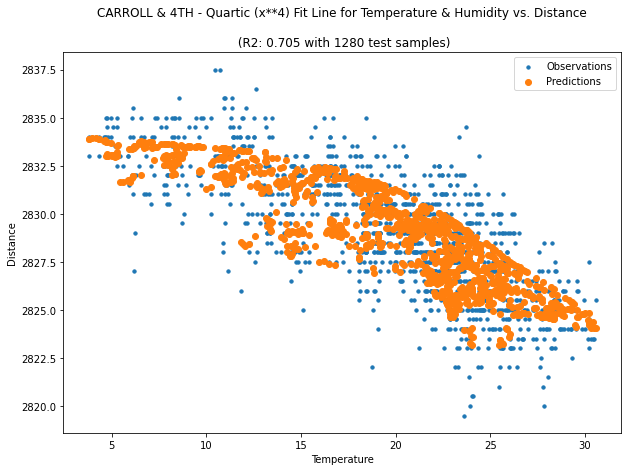

In [421]:
plt.figure(figsize=(10,7))

#plt.plot(X_train_temp, lm_temp.params[1]*X_train_temp+lm_temp.params[0], color='green')
plt.scatter(X_test['temp_C'], y_test, s=11, label='Observations')
plt.scatter(X_test['temp_C'], pred, label='Predictions')
plt.title('CARROLL & 4TH - Quartic (x**4) Fit Line for Temperature & Humidity vs. Distance\
\n\n (R2: {:.3f} with {:n} test samples)'.format(r2, len(X_test)))
plt.xlabel('Temperature')
plt.ylabel('Distance')
plt.legend()

# JAMAICA BAY

# Russell St. - Jamaica Bay

In [450]:
##### Query "Russell St - Jamaica Bay" Sensor Data from InfluxDB

client = InfluxDBClient(host='floodnet-influxdb.sonycproject.com', ssl=True, port=0, database='db0')

measure = 'distance'
table = 'msg'
app_id = 'deployment_two_app'
dev_id = 'sensor_8'
days_back = 400

query = 'SELECT "%s" ' \
        'FROM "%s" ' \
        'WHERE "app_id" = \'%s\' ' \
        'AND "dev_id" = \'%s\' ' \
        'AND "time" >= now() - %id'\
        % (measure, table, app_id, dev_id, days_back)

data = client.query(query)

value_data = data.raw['series'][0]['values']

russ_st = pd.DataFrame(value_data, columns =['datetime', 'distance'])

russ_st['datetime'] = pd.to_datetime(russ_st['datetime'], format='%Y-%m-%dT%H:%M:%S.%f')
russ_st['localtime'] = russ_st['datetime'].dt.tz_convert('US/Eastern')

russ_st = pd.DataFrame(russ_st.resample('10min', on='localtime').distance.mean()).reset_index() ## resample at 10_min intervals

print(russ_st)

//anaconda3/lib/python3.7/site-packages/urllib3/connectionpool.py:1020: InsecureRequestWarning: Unverified HTTPS request is being made to host 'floodnet-influxdb.sonycproject.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,


                      localtime     distance
0     2021-02-22 19:00:00-05:00  1233.000000
1     2021-02-22 19:10:00-05:00  1232.000000
2     2021-02-22 19:20:00-05:00  1232.000000
3     2021-02-22 19:30:00-05:00  1231.000000
4     2021-02-22 19:40:00-05:00  1232.000000
...                         ...          ...
36846 2021-11-05 17:00:00-04:00  2711.150000
36847 2021-11-05 17:10:00-04:00  2709.473684
36848 2021-11-05 17:20:00-04:00  2708.250000
36849 2021-11-05 17:30:00-04:00  2707.368421
36850 2021-11-05 17:40:00-04:00  2706.400000

[36851 rows x 2 columns]


<AxesSubplot:xlabel='localtime'>

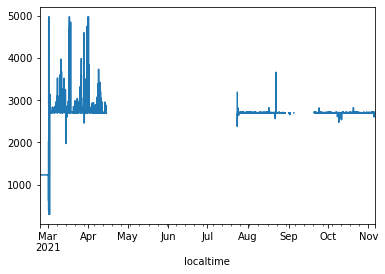

In [451]:
russ_st.set_index('localtime')['distance'].plot()

In [452]:
n_russ_st = russ_st[(russ_st.localtime.dt.hour > 22) | (russ_st.localtime.dt.hour < 5)]

In [453]:
cln_russ_st = n_russ_st[(n_russ_st['distance'] < 3500) & (n_russ_st['distance'] > 2000)]
cln_russ_st = cln_russ_st[(cln_russ_st.localtime.dt.date > pd.Timestamp(year=2021, month=3, day=5))]

<AxesSubplot:xlabel='localtime'>

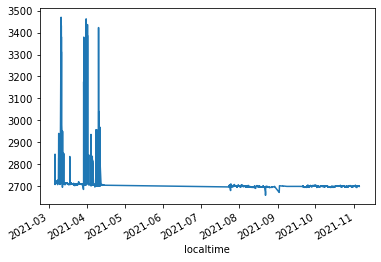

In [454]:
cln_russ_st.set_index('localtime')['distance'].plot()

In [455]:
lowercln_russ_st = cln_russ_st['distance'].mean() - (cln_russ_st['distance'].std())
uppercln_russ_st = cln_russ_st['distance'].mean() + (cln_russ_st['distance'].std())

In [456]:
cln_russ_st = cln_russ_st[cln_russ_st['distance'] < uppercln_russ_st]
cln_russ_st = cln_russ_st[cln_russ_st['distance'] > lowercln_russ_st]

Text(0, 0.5, 'Distance (cm)')

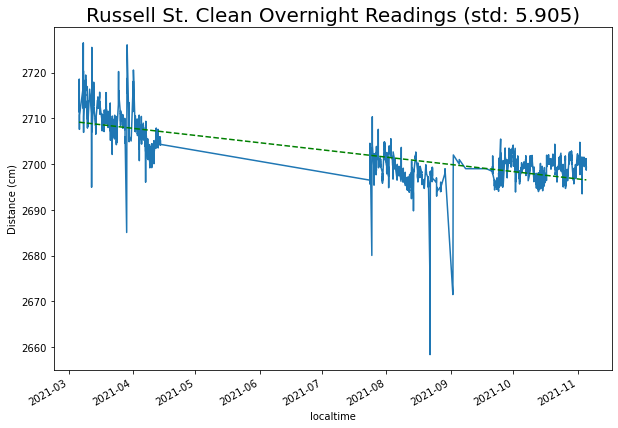

In [534]:
cln_russ_st.set_index('localtime')['distance'].plot(figsize=(10,7))
x = mdates.date2num(cln_russ_st['localtime'])
z = np.polyfit(x, cln_russ_st['distance'], 1)
p = np.poly1d(z)
plt.plot(x, p(x), "g--")
std = round(cln_russ_st['distance'].std(), 3)

plt.title(f'Russell St. Clean Overnight Readings (std: {std})', fontsize=20)
plt.ylabel('Distance (cm)')

In [458]:
cln_russ_st = cln_russ_st.merge(temps_jbay, on='localtime',how='inner').dropna()

Text(0, 0.5, 'Distance')

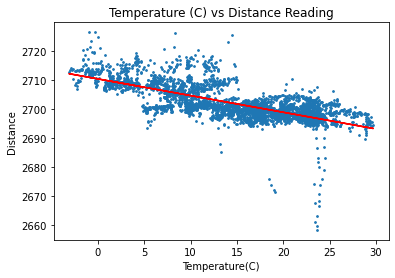

In [459]:
x_1 = cln_russ_st['temp_C']
x_2 = cln_russ_st['humidity']
y = cln_russ_st['distance']

plt.scatter(x_1, y, s=3)
m, b = np.polyfit(x_1, y, 1)
plt.plot(x_1, m*x_1 + b, color='red')
plt.title('Temperature (C) vs Distance Reading')
plt.xlabel('Temperature(C)')
plt.ylabel('Distance')

Text(0, 0.5, 'Distance')

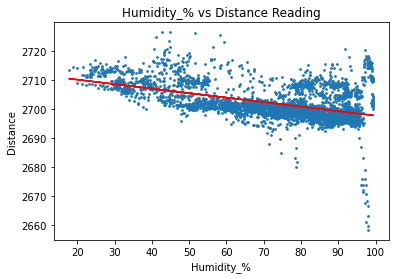

In [460]:
plt.scatter(x_2, y, s=3)
m, b = np.polyfit(x_2, y, 1)
plt.plot(x_2, m*x_2 + b, color='red')
plt.title('Humidity_% vs Distance Reading')
plt.xlabel('Humidity_%')
plt.ylabel('Distance')

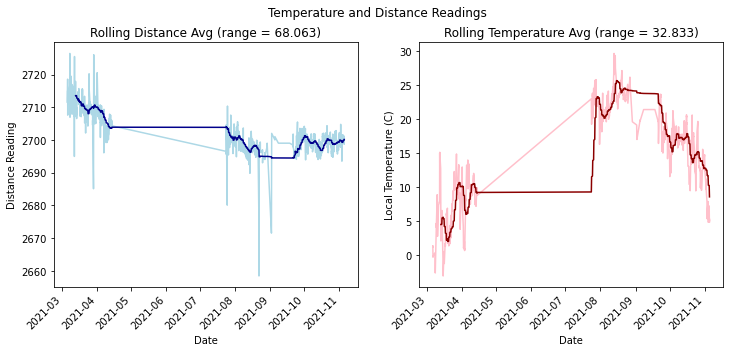

In [498]:
fig, ax = plt.subplots(1,2, figsize= (12,5))

cln_russ_st.set_index('localtime')['distance'].plot(label='Dist', color='lightblue', ax=ax[0])
cln_russ_st.set_index('localtime')['distance'].rolling(180).mean().plot(label='Dist', color='darkblue', ax=ax[0])
dist_range = round(cln_russ_st['distance'].max() - cln_russ_st['distance'].min(), 3)
ax[0].set_title(f'Rolling Distance Avg (range = {dist_range})')
ax[0].set_ylabel('Distance Reading')

cln_russ_st.set_index('localtime')['temp_C'].plot(label='Temp', color='pink', ax=ax[1])
cln_russ_st.set_index('localtime')['temp_C'].rolling(180).mean().plot(label='Temp', color='darkred', ax=ax[1])
temp_range = round(cln_russ_st['temp_C'].max() - cln_russ_st['temp_C'].min(), 3)
plt.suptitle('Temperature and Distance Readings')
ax[1].set_title(f'Rolling Temperature Avg (range = {temp_range})')
ax[1].set_ylabel('Local Temperature (C)')

for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=45)
    plt.xlabel('Date')

In [467]:
#### Temperature + Humdity

y = cln_russ_st['distance']
X = pd.DataFrame(cln_russ_st[['temp_C','humidity']])

n = 4

X_poly = X.copy()

for i in range(2,n+1):
    X_poly[f'temp_x{i}'] = cln_russ_st['temp_C']**i
    
for i in range(2,n+1):
    X_poly[f'humid_x{i}'] = cln_russ_st['humidity']**i


In [468]:
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.3)

lm = sm.OLS(y_train, sm.add_constant(X_train)).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               distance   R-squared:                       0.565
Model:                            OLS   Adj. R-squared:                  0.564
Method:                 Least Squares   F-statistic:                     453.1
Date:                Fri, 21 Jan 2022   Prob (F-statistic):               0.00
Time:                        14:34:01   Log-Likelihood:                -7829.7
No. Observations:                2800   AIC:                         1.568e+04
Df Residuals:                    2791   BIC:                         1.573e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2723.2140      6.152    442.628      0.000    2711.150    2735.278
temp_C         0.0504      0.132      0.383      0.702      -0.208       0.309
humidity      -0.7894      0.460     -1.716      0.086      -1.691       0.112
temp_x2       -0.1043      0.020     -5.315      0.000      -0.143      -0.066
temp_x3        0.0058      0.001      5.322      0.000       0.004       0.008
temp_x4    -9.581e-05   1.95e-05     -4.910      0.000      -0.000   -5.75e-05
humid_x2       0.0227      0.012      1.876      0.061      -0.001       0.046
humid_x3      -0.0003      0.000     -2.253      0.024      -0.001   -3.92e-05
humid_x4    1.401e-06   5.32e-07      2.634      0.008    3.58e-07    2.44e-06
==============================================================================
Omnibus:                     1220.363   Durbin-Watson:                   2.026
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            34769.524
Skew:                          -1.465   Prob(JB):                         0.00
Kurtosis:                      20.013   Cond. No.                     3.99e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.99e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [469]:
pred = lm.predict(sm.add_constant(X_test))

r2 = r2_score(y_test, pred)
print(r2)

0.5854276093725137


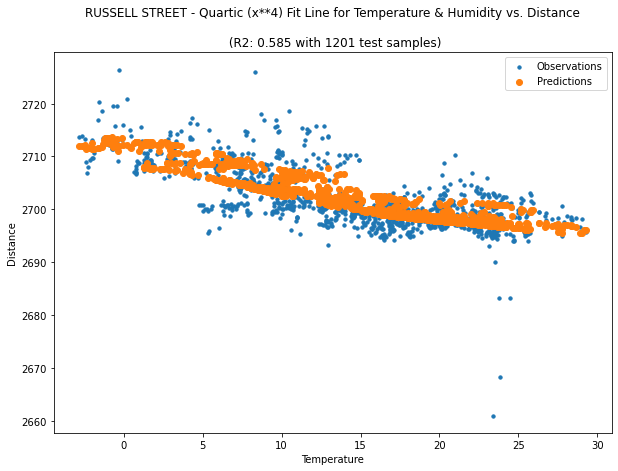

In [475]:
plt.figure(figsize=(10,7))

#plt.plot(X_train_temp, lm_temp.params[1]*X_train_temp+lm_temp.params[0], color='green')
plt.scatter(X_test['temp_C'], y_test, s=11, label='Observations')
plt.scatter(X_test['temp_C'], pred, label='Predictions')
plt.title('RUSSELL STREET - Quartic (x**4) Fit Line for Temperature & Humidity vs. Distance\
\n\n (R2: {:.3f} with {:n} test samples)'.format(r2, len(X_test)))
plt.xlabel('Temperature')
plt.ylabel('Distance')
plt.legend()

# Davenport Court - Jamaica Bay

In [476]:
##### Query "Davenport Court - Jamaica Bay" Sensor Data from InfluxDB

client = InfluxDBClient(host='floodnet-influxdb.sonycproject.com', ssl=True, port=0, database='db0')

measure = 'distance'
table = 'msg'
app_id = 'deployment_two_app'
dev_id = 'sensor_9'
days_back = 360

query = 'SELECT "%s" ' \
        'FROM "%s" ' \
        'WHERE "app_id" = \'%s\' ' \
        'AND "dev_id" = \'%s\' ' \
        'AND "time" >= now() - %id'\
        % (measure, table, app_id, dev_id, days_back)

data = client.query(query)

value_data = data.raw['series'][0]['values']

dav_ct = pd.DataFrame(value_data, columns =['datetime', 'distance'])

dav_ct['datetime'] = pd.to_datetime(dav_ct['datetime'], format='%Y-%m-%dT%H:%M:%S.%f')
dav_ct['localtime'] = dav_ct['datetime'].dt.tz_convert('US/Eastern')

dav_ct = pd.DataFrame(dav_ct.resample('10min', on='localtime').distance.mean()).reset_index() ## resample at 10_min intervals

print(dav_ct)

//anaconda3/lib/python3.7/site-packages/urllib3/connectionpool.py:1020: InsecureRequestWarning: Unverified HTTPS request is being made to host 'floodnet-influxdb.sonycproject.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,


                      localtime  distance
0     2021-02-22 19:00:00-05:00    1252.0
1     2021-02-22 19:10:00-05:00    1252.5
2     2021-02-22 19:20:00-05:00    1270.0
3     2021-02-22 19:30:00-05:00    1250.5
4     2021-02-22 19:40:00-05:00    1251.0
...                         ...       ...
36846 2021-11-05 17:00:00-04:00       NaN
36847 2021-11-05 17:10:00-04:00    2669.0
36848 2021-11-05 17:20:00-04:00    4963.0
36849 2021-11-05 17:30:00-04:00    4961.0
36850 2021-11-05 17:40:00-04:00    4961.0

[36851 rows x 2 columns]


<AxesSubplot:xlabel='localtime'>

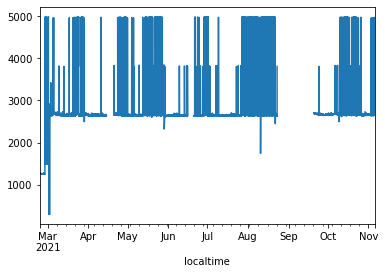

In [477]:
dav_ct.set_index('localtime')['distance'].plot()

In [491]:
n_dav_ct = dav_ct[(dav_ct.localtime.dt.hour > 22) | (dav_ct.localtime.dt.hour < 5)]

In [492]:
cln_dav_ct = n_dav_ct[(n_dav_ct['distance'] < 3500) & (n_dav_ct['distance'] > 2500)]
cln_dav_ct = cln_dav_ct[(cln_dav_ct.localtime.dt.date > pd.Timestamp(year=2021, month=3, day=5))]

<AxesSubplot:xlabel='localtime'>

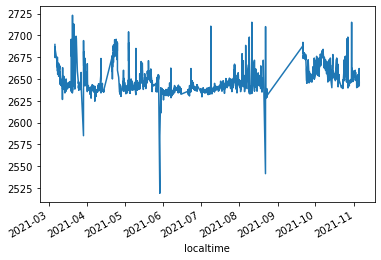

In [493]:
cln_dav_ct.set_index('localtime')['distance'].plot()

In [494]:
lowercln_dav_ct = cln_dav_ct['distance'].mean() - (cln_dav_ct['distance'].std())
uppercln_dav_ct = cln_dav_ct['distance'].mean() + (cln_dav_ct['distance'].std())

In [495]:
cln_dav_ct = cln_dav_ct[cln_dav_ct['distance'] < uppercln_dav_ct]
cln_dav_ct = cln_dav_ct[cln_dav_ct['distance'] > lowercln_dav_ct]

Text(0, 0.5, 'Distance (cm)')

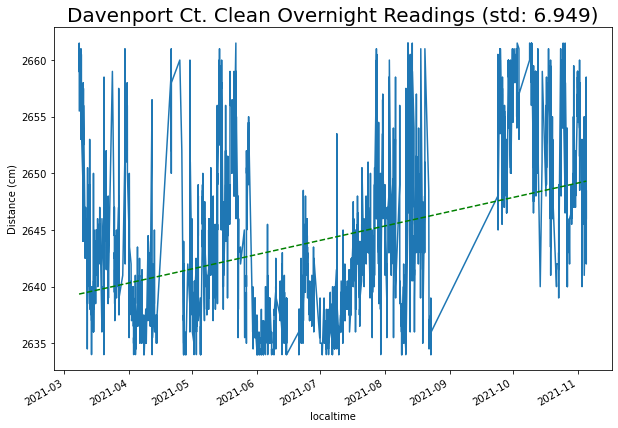

In [535]:
cln_dav_ct.set_index('localtime')['distance'].plot(figsize=(10,7))
x = mdates.date2num(cln_dav_ct['localtime'])
z = np.polyfit(x, cln_dav_ct['distance'], 1)
p = np.poly1d(z)
plt.plot(x, p(x), "g--")
std = round(cln_dav_ct['distance'].std(), 3)

plt.title(f'Davenport Ct. Clean Overnight Readings (std: {std})', fontsize=20)
plt.ylabel('Distance (cm)')

In [500]:
cln_dav_ct = cln_dav_ct.merge(temps_jbay, on='localtime',how='inner').dropna()

Text(0, 0.5, 'Distance')

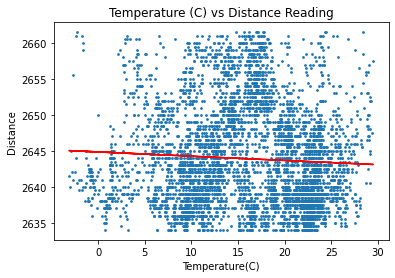

In [501]:
x_1 = cln_dav_ct['temp_C']
x_2 = cln_dav_ct['humidity']
y = cln_dav_ct['distance']

plt.scatter(x_1, y, s=3)
m, b = np.polyfit(x_1, y, 1)
plt.plot(x_1, m*x_1 + b, color='red')
plt.title('Temperature (C) vs Distance Reading')
plt.xlabel('Temperature(C)')
plt.ylabel('Distance')

Text(0, 0.5, 'Distance')

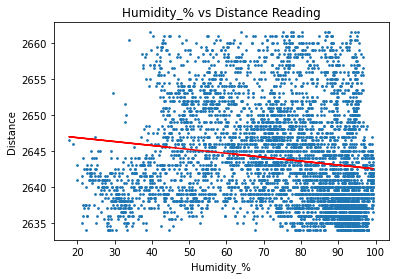

In [502]:
plt.scatter(x_2, y, s=3)
m, b = np.polyfit(x_2, y, 1)
plt.plot(x_2, m*x_2 + b, color='red')
plt.title('Humidity_% vs Distance Reading')
plt.xlabel('Humidity_%')
plt.ylabel('Distance')

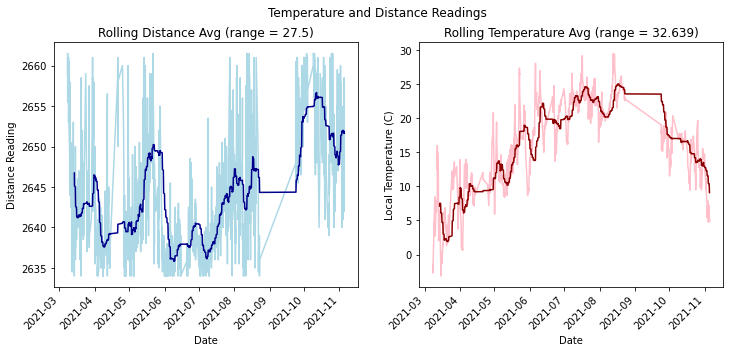

In [504]:
fig, ax = plt.subplots(1,2, figsize= (12,5))

cln_dav_ct.set_index('localtime')['distance'].plot(label='Dist', color='lightblue', ax=ax[0])
cln_dav_ct.set_index('localtime')['distance'].rolling(180).mean().plot(label='Dist', color='darkblue', ax=ax[0])
dist_range = round(cln_dav_ct['distance'].max() - cln_dav_ct['distance'].min(), 3)
ax[0].set_title(f'Rolling Distance Avg (range = {dist_range})')
ax[0].set_ylabel('Distance Reading')

cln_dav_ct.set_index('localtime')['temp_C'].plot(label='Temp', color='pink', ax=ax[1])
cln_dav_ct.set_index('localtime')['temp_C'].rolling(180).mean().plot(label='Temp', color='darkred', ax=ax[1])
temp_range = round(cln_dav_ct['temp_C'].max() - cln_dav_ct['temp_C'].min(), 3)
plt.suptitle('Temperature and Distance Readings')
ax[1].set_title(f'Rolling Temperature Avg (range = {temp_range})')
ax[1].set_ylabel('Local Temperature (C)')

for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=45)
    plt.xlabel('Date')

In [505]:
#### Temperature + Humdity

y = cln_dav_ct['distance']
X = pd.DataFrame(cln_dav_ct[['temp_C','humidity']])

n = 4

X_poly = X.copy()

for i in range(2,n+1):
    X_poly[f'temp_x{i}'] = cln_dav_ct['temp_C']**i
    
for i in range(2,n+1):
    X_poly[f'humid_x{i}'] = cln_dav_ct['humidity']**i


In [506]:
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.3)

lm = sm.OLS(y_train, sm.add_constant(X_train)).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               distance   R-squared:                       0.191
Model:                            OLS   Adj. R-squared:                  0.190
Method:                 Least Squares   F-statistic:                     104.1
Date:                Fri, 21 Jan 2022   Prob (F-statistic):          2.81e-156
Time:                        14:52:45   Log-Likelihood:                -11471.
No. Observations:                3527   AIC:                         2.296e+04
Df Residuals:                    3518   BIC:                         2.301e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2632.9916      8.357    315.074      0.000    2616.607    2649.376
temp_C        -1.8405      0.225     -8.185      0.000      -2.281      -1.400
humidity      -0.2141      0.625     -0.343      0.732      -1.439       1.011
temp_x2        0.3325      0.033     10.215      0.000       0.269       0.396
temp_x3       -0.0185      0.002    -10.454      0.000      -0.022      -0.015
temp_x4        0.0003   3.16e-05      9.937      0.000       0.000       0.000
humid_x2       0.0267      0.016      1.631      0.103      -0.005       0.059
humid_x3      -0.0004      0.000     -2.350      0.019      -0.001   -7.04e-05
humid_x4    1.875e-06   7.15e-07      2.623      0.009    4.74e-07    3.28e-06
==============================================================================
Omnibus:                      164.067   Durbin-Watson:                   1.956
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              187.173
Skew:                           0.564   Prob(JB):                     2.27e-41
Kurtosis:                       2.949   Cond. No.                     4.00e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large,  4e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [510]:
pred = lm.predict(sm.add_constant(X_test))

r2 = r2_score(y_test, pred)
print(r2)

0.17603692637137025


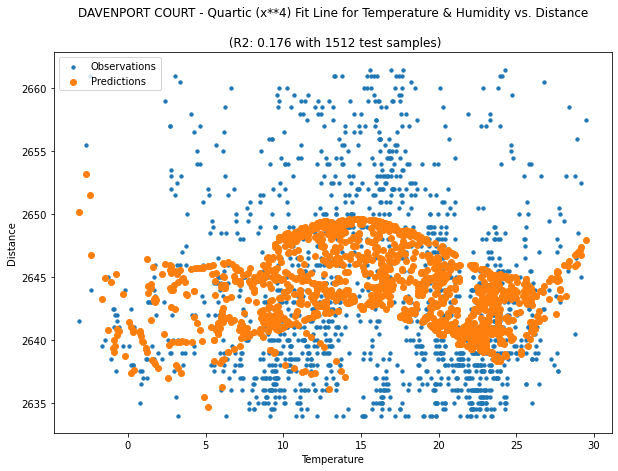

In [513]:
plt.figure(figsize=(10,7))

#plt.plot(X_train_temp, lm_temp.params[1]*X_train_temp+lm_temp.params[0], color='green')
plt.scatter(X_test['temp_C'], y_test, s=11, label='Observations')
plt.scatter(X_test['temp_C'], pred, label='Predictions')
plt.title('DAVENPORT COURT - Quartic (x**4) Fit Line for Temperature & Humidity vs. Distance\
\n\n (R2: {:.3f} with {:n} test samples)'.format(r2, len(X_test)))
plt.xlabel('Temperature')
plt.ylabel('Distance')
plt.legend()

In [314]:
hoyt5th_diff = nc_hoyt5th - nc_hoyt5th.mean()
smith9th_diff = cln_smith_9th.set_index('localtime') - cln_smith_9th.set_index('localtime').mean()
carroll4th_diff = cln_carroll4th.set_index('localtime') - cln_carroll4th.set_index('localtime').mean()

In [334]:
hoyt5th_diff.groupby(hoyt5th_diff.index.date).mean()

,distance
2020-11-02,7.533860
2020-11-03,5.418119
2020-11-04,3.867193
2020-11-05,3.566267
2020-11-06,2.274600
...,...
2021-11-01,2.195897
2021-11-02,2.084785
2021-11-03,1.575526
2021-11-04,3.811637


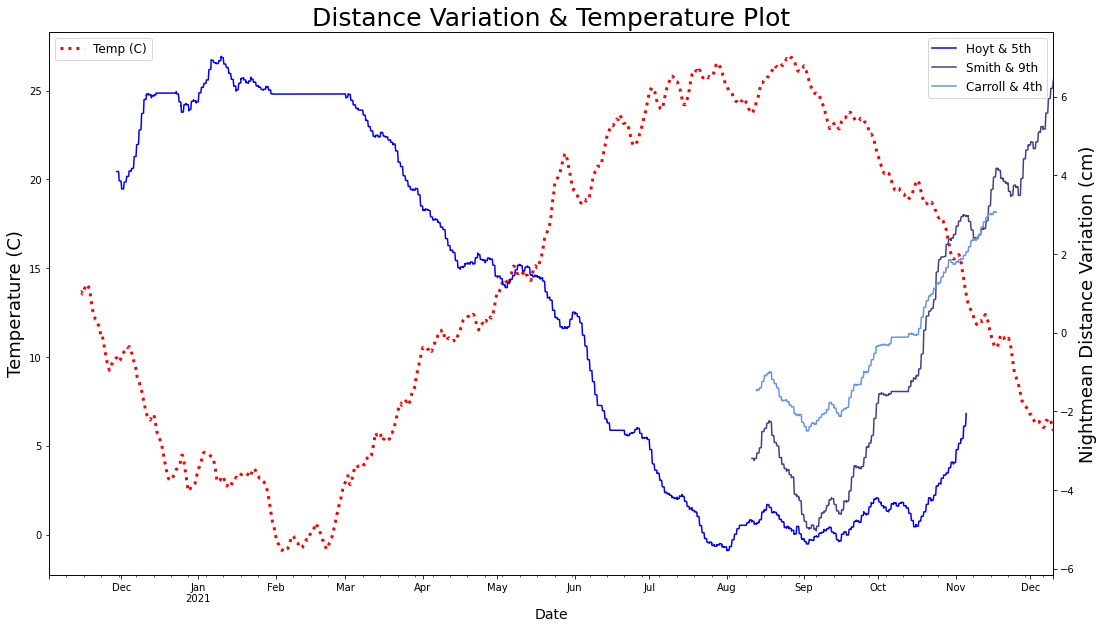

In [371]:
fig, ax = plt.subplots(figsize=(18,10))
# make a plot
temp_means.set_index('localtime')['temp_C'].rolling(2000).mean().plot(ax=ax, color='red',
        linestyle='dotted', linewidth=3, label='Temp (C)')
# set x-axis label
ax.set_xlabel("Date",fontsize=14)
# set y-axis label
ax.set_ylabel("Temperature (C)",fontsize=18)
ax.legend(loc=2, fontsize=12)

# twin object for two different y-axis on the sample plot

ax2=ax.twinx()
# make a plot with different y-axis using second axis object
hoyt5th_diff.rolling(1000).mean().plot(ax=ax2, color='blue')
smith9th_diff.rolling(1000).mean().plot(ax=ax2, color='darkslateblue')
carroll4th_diff.rolling(1000).mean().plot(ax=ax2, color='cornflowerblue')
ax2.set_ylabel("Nightmean Distance Variation (cm)", fontsize=18)
ax2.legend(['Hoyt & 5th','Smith & 9th','Carroll & 4th'], fontsize=12)

plt.title('Distance Variation & Temperature Plot', fontsize=25)

plt.savefig("sensor_distance_fig.png", facecolor='white', transparent=False)

<AxesSubplot:xlabel='localtime'>

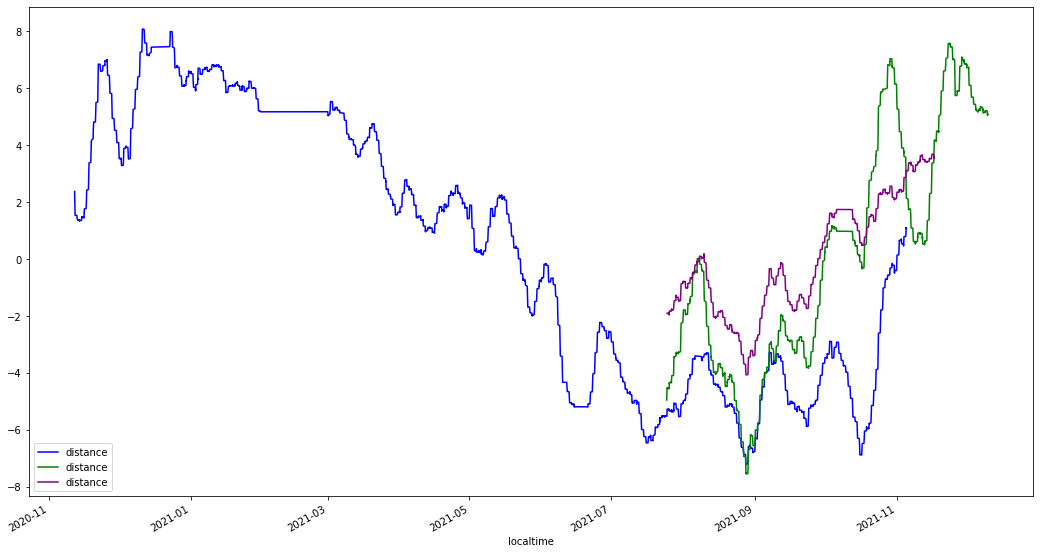

In [313]:
fig, ax = plt.subplots(figsize=(18,10))


(nc_hoyt5th - nc_hoyt5th.mean()).rolling(360).mean().plot(ax=ax, color='blue')
(cln_smith_9th.set_index('localtime') - cln_smith_9th.set_index('localtime').mean()).rolling(360).mean().plot(ax=ax, color='green')
(cln_carroll4th.set_index('localtime') - cln_carroll4th.set_index('localtime').mean()).rolling(360).mean().plot(ax=ax, color='purple')